# EE514 assignment part 1 starter code

Using sensors to predict activity. This part of the assignment uses the [ExtraSensory dataset](http://extrasensory.ucsd.edu/). You can download the dataset from [here](http://extrasensory.ucsd.edu/data/primary_data_files/ExtraSensory.per_uuid_features_labels.zip). The starter code expects that this dataset has been unpacked in a folder called `data` that is in the same parent folder as this notebook. You can read more about the dataset in [this README file](http://extrasensory.ucsd.edu/data/primary_data_files/README.txt).

In [282]:
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import statistics
import csv

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

## Location of the .csv.gz files

In [283]:
data_dir = 'C:/Users/amuru/OneDrive/Documents/Assignment/Data'


## Some utility functions

The first one loads a pandas dataframe given a user UUID. The second one extracts specified feature columns $X$ and target column $y$ from a dataframe and converts these to numpy.

In [284]:
def load_data_for_user(uuid):
    return pd.read_csv(data_dir + '/' + (uuid + '.features_labels.csv'))

def get_features_and_target(df, feature_names, target_name):
    
    # select out features and target columns and convert to numpy
    X = df[feature_names].to_numpy()
    y = df[target_name].to_numpy()
    
    # remove examples with no label
    has_label = ~np.isnan(y)
    X = X[has_label,:]
    y = y[has_label]
    return X, y

## Load in some data 
Load in the data for a user and display the first few rows of the dataframe

In [285]:
df = load_data_for_user('1155FF54-63D3-4AB2-9863-8385D0BD0A13')
df.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1464129912,1.011438,0.012573,0.023013,0.041240,1.006184,1.010868,1.016028,0.935099,6.684536,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
1,1464129950,1.011233,0.009356,-0.005622,0.016687,1.006338,1.010926,1.016657,1.732968,6.684569,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
2,1464130031,1.013422,0.018068,-0.008593,0.039286,1.004077,1.012983,1.021926,1.464639,6.684453,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
3,1464130109,1.014891,0.016400,0.021383,0.038825,1.005934,1.014670,1.023000,1.440043,6.684483,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
4,1464130130,1.017487,0.022632,-0.012891,0.037226,1.006040,1.017587,1.028168,1.937362,6.684364,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2


## What columns are available?

In [286]:
print(df.columns.to_list())

['timestamp', 'raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_gyro:magnitude_stats:std', 'proc_gyro:magnitude_stat

## Feature selection

The columns that start with `label:` correspond to potential y values. Let's look at using the accelerometer features. These start with `raw_acc:` and `watch_acceleration:`

In [287]:
acc_sensors = [s for s in df.columns if 
               s.startswith('raw_acc:') or 
               s.startswith('watch_acceleration:')]

target_column = 'label:FIX_walking'

## Extract our training data

In [288]:
X_train, y_train = get_features_and_target(df, acc_sensors, target_column)
print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')

2681 examples with 158.0 positives


## Preprocessing

We want to make the learning problem easier by making all columns have a mean of zero and a standard deviation of one. There are also lots of missing values in this dataset. We'll use mean imputation here to get rid of them. Since our data is scaled to have zero mean, this will just zero out missing values.

In [289]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train = scaler.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)

## Fitting a model
Let's fit a logistic regression model to this user. We can then test it's predictive power on a different user

In [290]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=1.0)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Training accuracy

Let's see the accuracy on the training set. The score function can be used to do this:

In [291]:
print(f'Training accuracy: {clf.score(X_train, y_train):0.4f}')

Training accuracy: 0.9750


Looks like the model can fit the training data reasonably well anyway. But this says nothing about how well it will generalize to new data. The dataset is also unbalanced, so this figure may be misleading. How accurate would we be if we just predicted zero each time?

In [292]:
1 - y_train.sum() / y_train.shape[0]

0.9410667661320403

Oh wow. Our model may not be that great after all. Let's try to calculate balanced accuracy, which should better reflect how well the model does on the training data

In [293]:
y_pred = clf.predict(X_train)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_train, y_pred):0.4f}')

Balanced accuracy (train): 0.8354


## Testing the model

Ok, it seems our model has fit the training data well. How well does it perform on unseen test data? Let's load the data in for a different user.

In [294]:
df_test = load_data_for_user('11B5EC4D-4133-4289-B475-4E737182A406')
X_test, y_test = get_features_and_target(df_test, acc_sensors, target_column)
print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')

2681 examples with 158.0 positives


We also need to preprocess as before. **Note**: we are using the scaler and imputer fit to the training data here. It's very important that you do not call `fit` or `fit_transform` here! Think about why.

In [295]:
X_test = imputer.transform(scaler.transform(X_test))

## Test accuracy

In [296]:
print(f'Test accuracy: {clf.score(X_test, y_test):0.4f}')

Test accuracy: 0.9746


In [297]:
y_pred = clf.predict(X_test)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_test, y_pred):0.4f}')

Balanced accuracy (train): 0.7327


In [298]:
# Selecting 5 different users and testing the model on each indiviually
# Evaluating mean and variance of the balanced accuracy

u_str = ['00EABED2-271D-49D8-B599-1D4A09240601', '0A986513-7828-4D53-AA1F-E02D6DF9561B','0BFC35E2-4817-4865-BFA7-764742302A2D','0E6184E1-90C0-48EE-B25A-F1ECB7B9714E','1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842']
x_list = []



def store_list(x) :          # function to store list
    x_list.append(x)
    
    
    
for u in u_str:
    df_test = load_data_for_user(u)
    X_test, y_test = get_features_and_target(df_test, acc_sensors, target_column)
    print("UUID : ", u)
    print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')
    X_test = imputer.transform(scaler.transform(X_test))
    print(f'Test accuracy: {clf.score(X_test, y_test):0.4f}')
    y_pred = clf.predict(X_test)
    print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_test, y_pred):0.4f}')
    x = float(format(metrics.balanced_accuracy_score(y_test, y_pred)))
    
    store_list(x)
  
    print(" ")

x_sum = sum(x_list)
x_mean = x_sum/len(x_list)
print("Mean of Balanced Accuracy : ",x_mean)

var = statistics.variance(x_list)
print("Variance of Balanced Accuracy : ",var)

UUID :  00EABED2-271D-49D8-B599-1D4A09240601
2681 examples with 158.0 positives
Test accuracy: 0.9320
Balanced accuracy (train): 0.6230
 
UUID :  0A986513-7828-4D53-AA1F-E02D6DF9561B
2681 examples with 158.0 positives
Test accuracy: 0.9497
Balanced accuracy (train): 0.6765
 
UUID :  0BFC35E2-4817-4865-BFA7-764742302A2D
2681 examples with 158.0 positives
Test accuracy: 0.7961
Balanced accuracy (train): 0.4889
 
UUID :  0E6184E1-90C0-48EE-B25A-F1ECB7B9714E
2681 examples with 158.0 positives
Test accuracy: 0.8157
Balanced accuracy (train): 0.5791
 
UUID :  1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842
2681 examples with 158.0 positives
Test accuracy: 0.8907
Balanced accuracy (train): 0.6433
 
Mean of Balanced Accuracy :  0.602156029135768
Variance of Balanced Accuracy :  0.005256796063441051


In [299]:
#Combining the Data of Five users and adding it into a single data frame

u_str = ['00EABED2-271D-49D8-B599-1D4A09240601','0A986513-7828-4D53-AA1F-E02D6DF9561B','0BFC35E2-4817-4865-BFA7-764742302A2D','0E6184E1-90C0-48EE-B25A-F1ECB7B9714E','1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842']


combined_csv = pd.concat([pd.read_csv(data_dir + '/' + (u + '.features_labels.csv')) for u in u_str])
df_csv = pd.DataFrame(combined_csv)  
df_csv.to_csv("Amurusha_csv.csv", index=False, encoding='utf-8-sig')



In [300]:
df_combined = pd.read_csv(data_dir +'/'+'Amurusha_csv.csv')

## Increasing training data using splits


In [301]:
from sklearn.model_selection import train_test_split

In [302]:
X_test, y_test = get_features_and_target(df_combined, acc_sensors, target_column)

In [303]:
# Splitting the data set into 80-20 (80 = Training set ,20 = Validation set ) INTRODUCING VALIDATION SET

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) # 0.25 x 0.8 = 0.2

In [304]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train = scaler.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)

In [305]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=1.0)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [306]:
print(f'Logistic Regression with C= 1.0 Training accuracy: {clf.score(X_train, y_train):0.4f}')

Logistic Regression with C= 1.0 Training accuracy: 0.9729


In [307]:
1 - y_train.sum() / y_train.shape[0]

0.9393656716417911

In [308]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.8185


In [309]:
print('Classification Report\nLogistic Regression with C = 1.0\n ')
print(classification_report(y_val, y_pred))

Classification Report
Logistic Regression with C = 1.0
 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       509
         1.0       0.86      0.64      0.73        28

    accuracy                           0.98       537
   macro avg       0.92      0.82      0.86       537
weighted avg       0.97      0.98      0.97       537



In [310]:
#AUC value calculation

#from sklearn .metrics import roc_auc_score
#auc = np.round(roc_auc_score(y_val, y_pred), 3)
#print("AUC for our data is {}". format(auc))
#plt.plot(auc)
#plt.show()

AUC for model data is:  0.8184816166152119


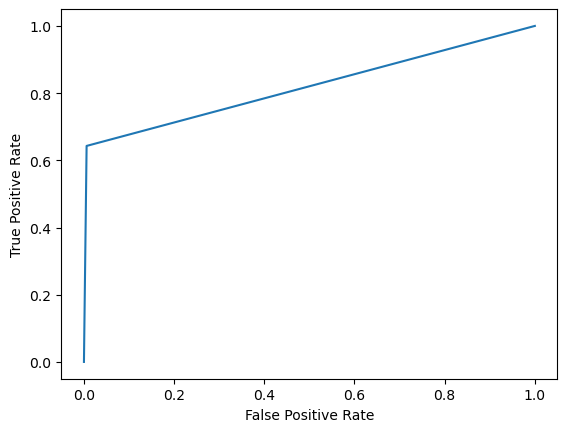

In [311]:
#ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)
auc = metrics.roc_auc_score(y_val, y_pred)


print("AUC for model data is: ",auc)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [312]:
# Changing C Parameter
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=0.01)
clf.fit(X_train, y_train)


LogisticRegression(C=0.01, max_iter=1000, solver='liblinear')

In [313]:
print(f'Logistic Regression with C= 0.01 Training accuracy: {clf.score(X_train, y_train):0.4f}')

Logistic Regression with C= 0.01 Training accuracy: 0.9701


In [314]:
1 - y_train.sum() / y_train.shape[0]

0.9393656716417911

In [315]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.8721


In [316]:
print('LogisticRegression with C = 0.01 Classification Report\n')
print(classification_report(y_val, y_pred))

LogisticRegression with C = 0.01 Classification Report

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       509
         1.0       0.88      0.75      0.81        28

    accuracy                           0.98       537
   macro avg       0.93      0.87      0.90       537
weighted avg       0.98      0.98      0.98       537



In [317]:
#AUC value calculation

#from sklearn .metrics import roc_auc_score
#auc = np.round(roc_auc_score(y_val, y_pred), 3)
#print("AUC for our data is {}". format(auc))
#plt.plot(auc)
#plt.show()

AUC for model data is :  0.8720530451866404


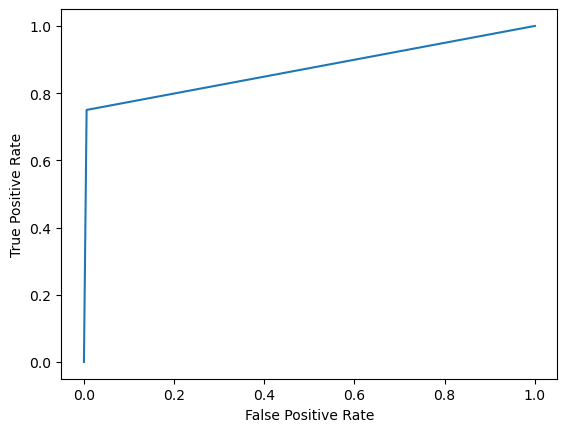

In [318]:
#ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)
auc = metrics.roc_auc_score(y_val, y_pred)


print("AUC for model data is : ",auc)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Trying Another model

In [319]:
from sklearn.svm import SVC
clf = SVC(C= 1, kernel='linear', gamma= 1)
clf.fit(X_train, y_train)

SVC(C=1, gamma=1, kernel='linear')

In [320]:
print(f'SVM Training accuracy for C = 1 : {clf.score(X_train, y_train):0.4f}')

SVM Training accuracy for C = 1 : 0.9715


In [321]:
1 - y_train.sum() / y_train.shape[0]

0.9393656716417911

In [322]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.8393


In [323]:
print('SVM with linear kernel Classification Report \n C=1\n gamma =1 \n')
print(classification_report(y_val, y_pred))

SVM with linear kernel Classification Report 
 C=1
 gamma =1 

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       509
         1.0       1.00      0.68      0.81        28

    accuracy                           0.98       537
   macro avg       0.99      0.84      0.90       537
weighted avg       0.98      0.98      0.98       537



In [324]:
#AUC value calculation

#from sklearn .metrics import roc_auc_score
#auc = np.round(roc_auc_score(y_val, y_pred), 3)
#print("AUC for our data is {}". format(auc))
#plt.plot(auc)
#plt.show()

AUC for our data is :  0.8392857142857143


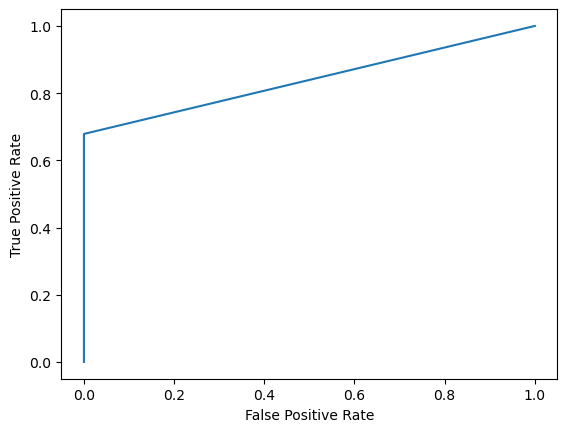

In [325]:
#ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)
auc = metrics.roc_auc_score(y_val, y_pred)


print("AUC for our data is : ",auc)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## changing C parameter from 1 to 0.01

In [326]:
from sklearn.svm import SVC
clf = SVC(C= 0.01, kernel='linear', gamma= 1)
clf.fit(X_train, y_train)

SVC(C=0.01, gamma=1, kernel='linear')

In [327]:
print(f'SVM Training accuracy for C = .01 : {clf.score(X_train, y_train):0.4f}')

SVM Training accuracy for C = .01 : 0.9697


In [328]:
1 - y_train.sum() / y_train.shape[0]

0.9393656716417911

In [329]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.8740


In [330]:
print('SVM with linear kernel Classification Report \n C=0.01 \n gamma =1 \n')
print(classification_report(y_val, y_pred))

SVM with linear kernel Classification Report 
 C=0.01 
 gamma =1 

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       509
         1.0       0.95      0.75      0.84        28

    accuracy                           0.99       537
   macro avg       0.97      0.87      0.92       537
weighted avg       0.98      0.99      0.98       537



AUC for our data is :  0.8740176817288802


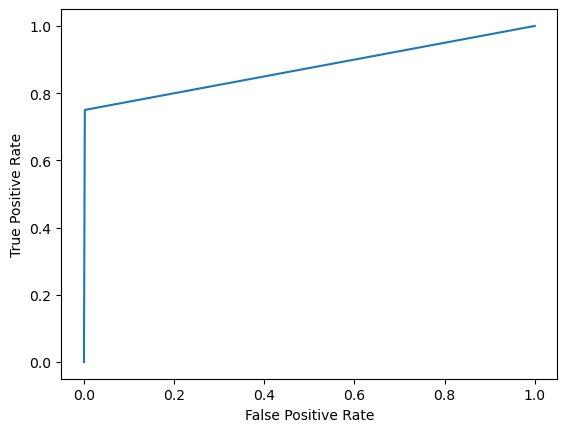

In [331]:
#ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)
auc = metrics.roc_auc_score(y_val, y_pred)


print("AUC for our data is : ",auc)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##  Changing hyper parameter - gamma from 1 to 0.5

In [332]:
from sklearn.svm import SVC
clf = SVC(C=0.01, kernel='linear', gamma= 0.5)
clf.fit(X_train, y_train)

SVC(C=0.01, gamma=0.5, kernel='linear')

In [333]:
print(f'SVM Training accuracy for C = 0.1 & gamma = 0.5 : {clf.score(X_train, y_train):0.4f}')

SVM Training accuracy for C = 0.1 & gamma = 0.5 : 0.9697


In [334]:
1 - y_train.sum() / y_train.shape[0]

0.9393656716417911

In [335]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.8562


In [336]:
print('SVM with linear kernel Classification Report \n gamma = 0.5\n')
print(classification_report(y_val, y_pred))

SVM with linear kernel Classification Report 
 gamma = 0.5

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       509
         1.0       0.95      0.71      0.82        28

    accuracy                           0.98       537
   macro avg       0.97      0.86      0.90       537
weighted avg       0.98      0.98      0.98       537



In [337]:
#AUC value calculation

#from sklearn .metrics import roc_auc_score
#auc = np.round(roc_auc_score(y_val, y_pred), 3)
#print("AUC for our data is {}". format(auc))
#plt.plot(auc)
#plt.show()

AUC for our data is :  0.8561605388717375


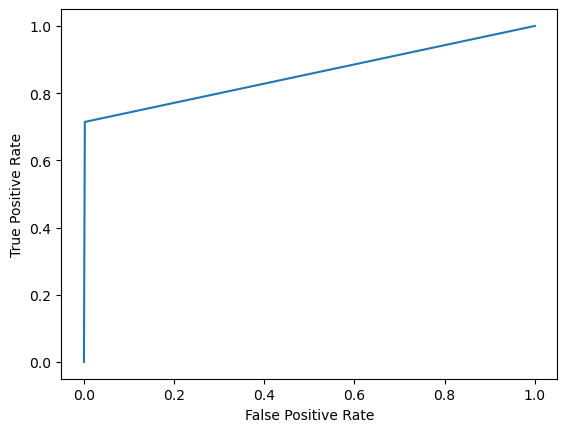

In [338]:
#ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)
auc = metrics.roc_auc_score(y_val, y_pred)


print("AUC for our data is : ",auc)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Changing Kernel Type

In [339]:
clf = SVC(C= .01, kernel='poly', gamma= 1)
clf.fit(X_train, y_train)

SVC(C=0.01, gamma=1, kernel='poly')

In [340]:
print(f'Training accuracy: {clf.score(X_train, y_train):0.4f}')

Training accuracy: 1.0000


In [341]:
1 - y_train.sum() / y_train.shape[0]

0.9393656716417911

In [342]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.8218


In [343]:
print('SVM with Poly kernel Classification Report\n')
print(classification_report(y_val, y_pred))

SVM with Poly kernel Classification Report

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       509
         1.0       0.36      0.71      0.48        28

    accuracy                           0.92       537
   macro avg       0.67      0.82      0.72       537
weighted avg       0.95      0.92      0.93       537



In [344]:
#AUC value calculation

#from sklearn .metrics import roc_auc_score
#auc = np.round(roc_auc_score(y_val, y_pred), 3)
#print("AUC for our data is {}". format(auc))
#plt.plot(auc)
#plt.show()

AUC for our data is :  0.8217793993825429


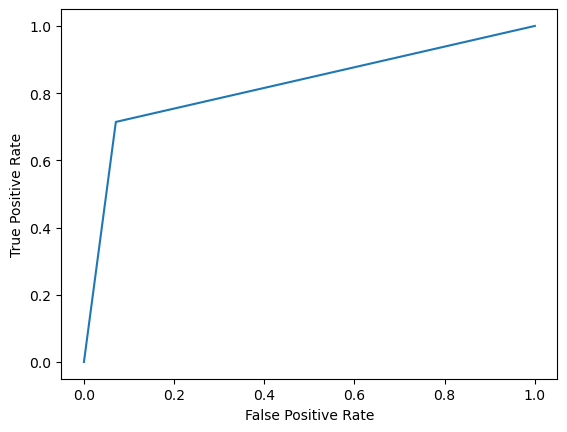

In [345]:
#ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)
auc = metrics.roc_auc_score(y_val, y_pred)


print("AUC for our data is : ",auc)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()